<a href="https://colab.research.google.com/github/midnitefantasy/Human-Activity-Recognition-Classification/blob/main/Klasifikasi_HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Load dataset menjadi dataframe**

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats

#Load File
def load_data(data1):
  df = pd.read_csv(data1)
  df.index.name = None
  print(df.shape)
  return df

df = load_data('gdrive/My Drive/Data/Data 5 Bebas.csv')
df.head()


(15957, 7)


,gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z,label
0,0.033598,-0.109956,-0.005498,0.213084,0.663194,9.792285,stand
1,0.810007,1.065960,-1.317025,0.648829,0.598550,9.813833,stand
2,0.026878,-0.232740,0.081856,0.974440,0.806846,9.801862,stand
3,-0.028711,-0.266948,0.003054,0.936133,0.751779,9.552865,stand
4,-0.041539,0.133780,-0.065973,0.126893,0.658406,9.540894,stand


## **VISUALISASI DATA**

In [3]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
def plot_activity(label, data):
  df = data[data['label'] == label][['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']][:150]
  axis = df.plot(subplots= True, figsize=(10,10), title = label)

  for ax in axis:
    ax.legend(loc='lower left', bbox_to_anchor = (1.0,0.5))

SIT

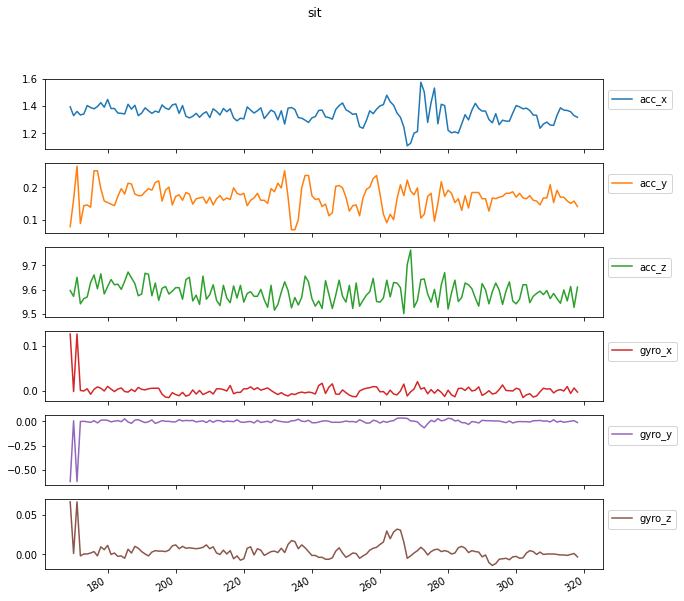

In [ ]:
plot_activity("sit", df)

STAND

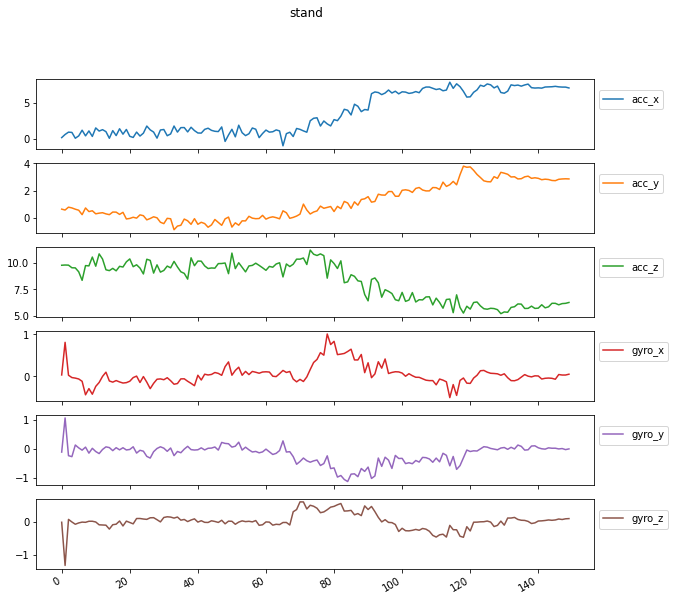

In [ ]:
plot_activity("stand", df)

LAYDOWN

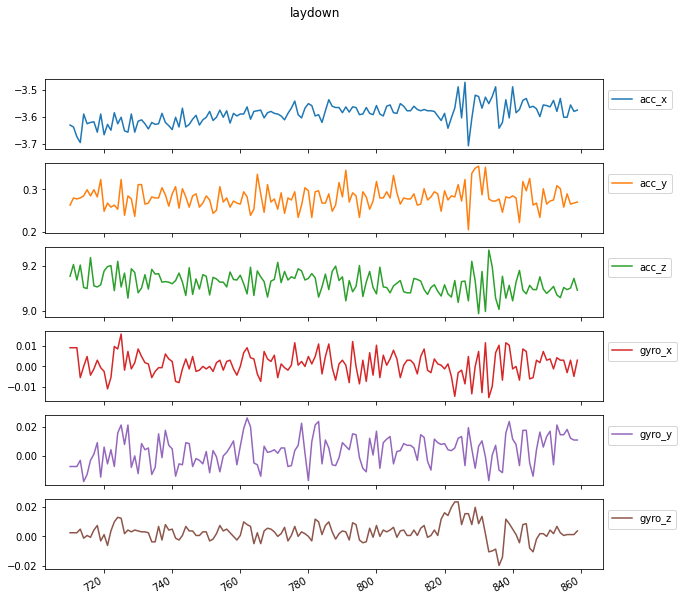

In [ ]:
plot_activity("laydown", df)

WALK

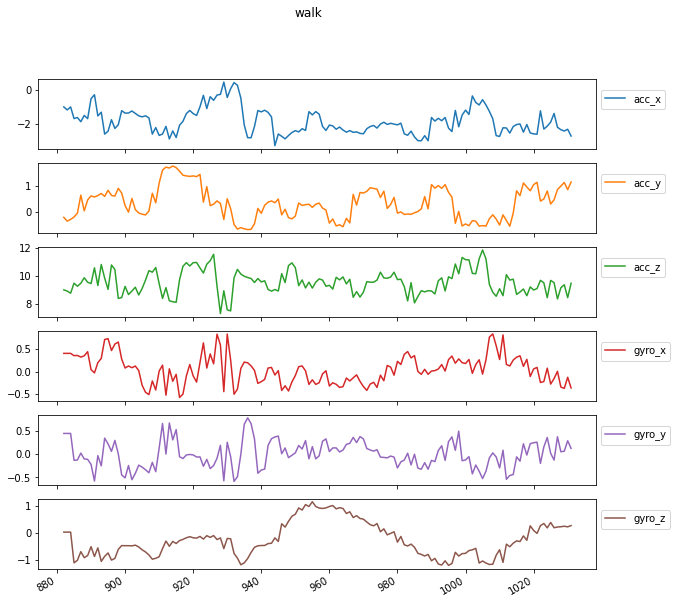

In [ ]:
plot_activity("walk", df)

WALK UPSTAIRS

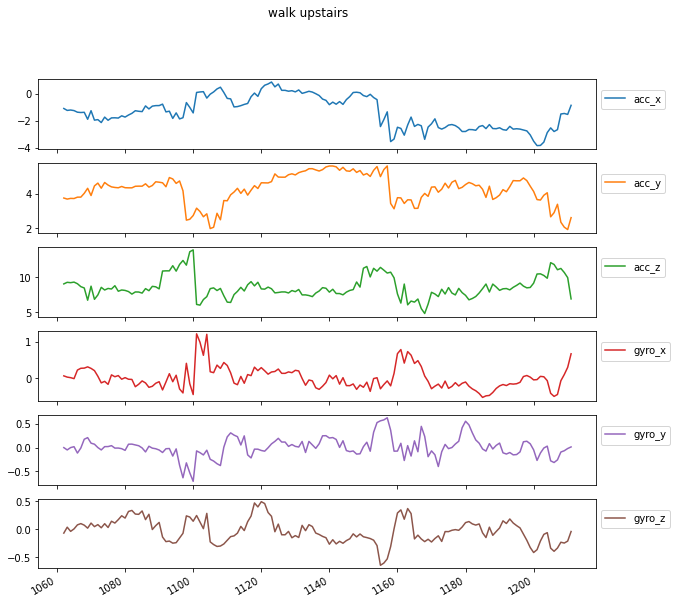

In [ ]:
plot_activity("walk upstairs", df)

WALK DOWNSTAIRS

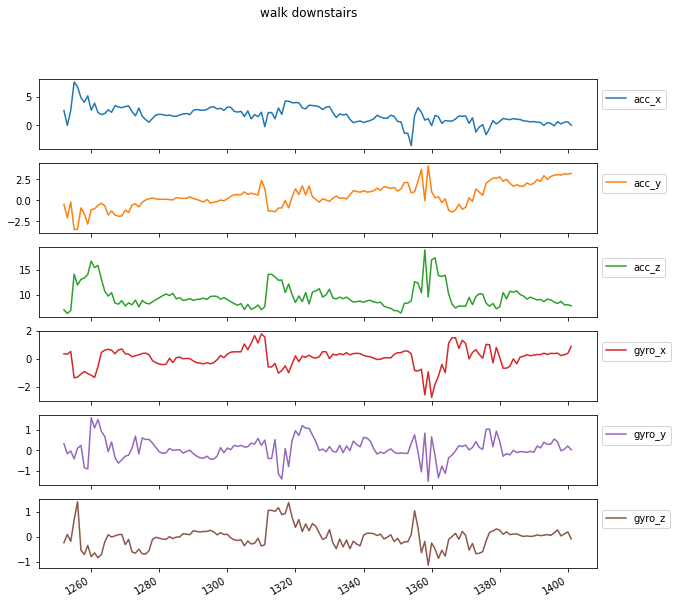

In [ ]:
plot_activity("walk downstairs", df)

RUN

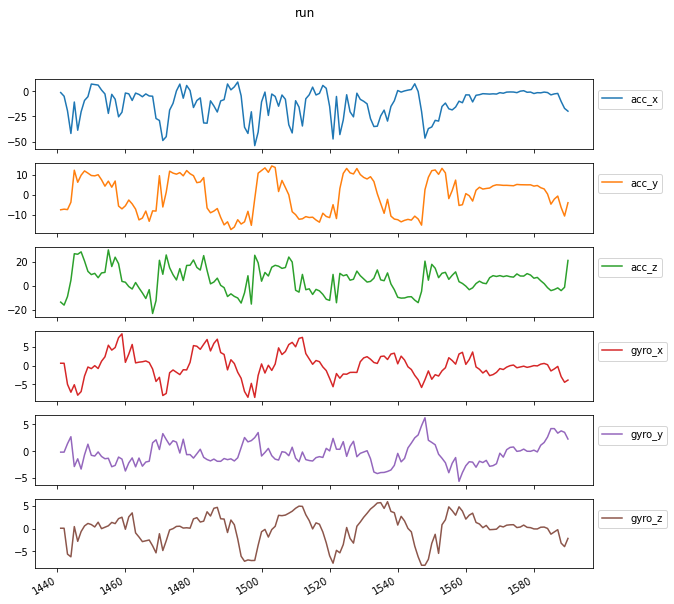

In [ ]:
plot_activity("run", df)

JUMP

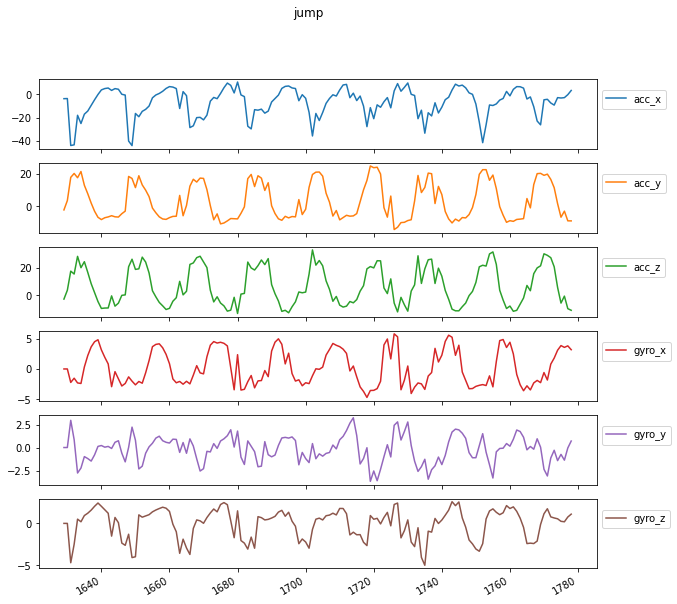

In [ ]:
plot_activity("jump", df)

## **PRE-PROCESSING : Ekstraksi Fitur & Pemisahan Train dan Test Data**

In [12]:
#UNTUK STANDARDISASI
scaler = StandardScaler()
from statsmodels.tsa.ar_model import AR

def ekstraksi (df):
  l_dfrange = []
  l_dfrange_coeff_a =[]
  l_dfrange_coeff_g =[]
  l_dfrange_sma=[]
  step = 10
  gr = df.groupby(['label'], as_index=False)
  l_grouped = list(gr)
  for i in range(len(l_grouped)):
    df_range = pd.DataFrame(l_grouped[i][1])
    df_range["ID"] = np.arange(len(df_range))//step
    #df_range_new['sum_acc']= df_range.iloc[:, -7:-2].sum(axis=1)
    df_range_new = df_range.groupby('ID').agg({
      'label' : 'first',
      'gyro_x': ['mean', 'std', 'max', 'min', 'mad', get_IQR], 
      'gyro_y': ['mean', 'std', 'max', 'min', 'mad', get_IQR],
      'gyro_z': ['mean', 'std', 'max', 'min', 'mad', get_IQR], 
      'acc_x': ['mean', 'std', 'max', 'min', 'mad', get_IQR],
      'acc_y': ['mean', 'std', 'max', 'min', 'mad', get_IQR], 
      'acc_z': ['mean', 'std', 'max', 'min', 'mad', get_IQR]})
    df_range_acc = df_range.groupby('ID')[['acc_x','acc_y','acc_z']]
    df_range_coeff_acc = coeff(df_range, 'acc_x','acc_y','acc_z', 'ID')
    df_range_coeff_gyro = coeff(df_range, 'gyro_x','gyro_y','gyro_z', 'ID')
    df_range_sma = calc_sma(df_range, 'acc_x','acc_y','acc_z', 'ID')

    l_dfrange_sma.append(df_range_sma)
    l_dfrange.append(df_range_new)
    l_dfrange_coeff_a.append(df_range_coeff_acc)
    l_dfrange_coeff_g.append(df_range_coeff_gyro)
  
  df_range_new = pd.concat(l_dfrange, axis = 0, ignore_index=False)
  df_range_sma = pd.concat(l_dfrange_sma, axis = 0, ignore_index=False)
  df_range_coeff_a = pd.concat(l_dfrange_coeff_a, axis = 0, ignore_index=False)
  df_range_coeff_g = pd.concat(l_dfrange_coeff_g, axis = 0, ignore_index=False)
  df_range_new.reset_index(drop=True, inplace=True)
  df_range_coeff_a.reset_index(drop=True, inplace=True)
  df_range_coeff_g.reset_index(drop=True, inplace=True)
  df_range_sma.reset_index(drop=True, inplace=True)
  df_range_new = pd.concat([df_range_new, df_range_coeff_a, df_range_coeff_g], axis=1)
  df_range_new.columns = ["_".join(x) for x in df_range_new.columns.ravel()]
  df_range_new = pd.concat([df_range_new, df_range_sma], axis=1)

  #arcoeff

  return df_range_new

def AR_model (data):
  new_data = data.drop('label', axis=1)
  armodel = AR(new_data)
  armodel_fit = armodel.fit()
  hasil = armodel_fit.params
  return hasil

def coeff(data, col1, col2, col3, ID):
  new_data = data.groupby(ID)[[col1, col2, col3]].corr().unstack()
  new_data = new_data.drop(new_data.columns[[0, 3, 4, 6, 7, 8]], axis=1)
  return new_data

def calc_sma_adv_for_window(data):
    return np.sum(data - np.mean(data) / len(data))

def calc_sma(data, col1, col2, col3, ID):
  sum_data = data.groupby(ID)[[col1, col2, col3]].apply(lambda x: np.sum(np.abs(x)))
  sum_x = sum_data.sum(axis=1)
  mean_data = data.groupby(ID)[[col1, col2, col3]].mean()
  panjang_data = len(data)
  sma_sim = sum_x/panjang_data
  return sma_sim
    
def get_IQR (column):
 q1 = np.percentile(column, 25)
 q3 = np.percentile(column, 75)
 iqr = q3 - q1
 return iqr




#1 Ekstraksi fitur
df_range= ekstraksi(df)
#print(df_range)
print(df_range)
print(df_range.columns)
#AR_model(df)
#print(type(armodel))
#print(armodel)
  




        label_first  gyro_x_mean  ...  gyro_y_gyro_z         0
0              jump     0.251432  ...      -0.816575  0.231727
1              jump    -0.051740  ...       0.657571  0.112133
2              jump     0.734871  ...      -0.374927  0.198683
3              jump    -0.992962  ...       0.112295  0.166980
4              jump     2.616641  ...       0.590363  0.166081
...             ...          ...  ...            ...       ...
1594  walk upstairs    -0.745900  ...       0.497124  0.067472
1595  walk upstairs    -0.234427  ...      -0.922899  0.070697
1596  walk upstairs    -0.182832  ...       0.213537  0.067341
1597  walk upstairs    -0.148704  ...      -0.477464  0.073634
1598  walk upstairs    -0.084590  ...      -0.995292  0.073804

[1599 rows x 44 columns]
Index([   'label_first',    'gyro_x_mean',     'gyro_x_std',     'gyro_x_max',
           'gyro_x_min',     'gyro_x_mad', 'gyro_x_get_IQR',    'gyro_y_mean',
           'gyro_y_std',     'gyro_y_max',     'gyro_y_min',

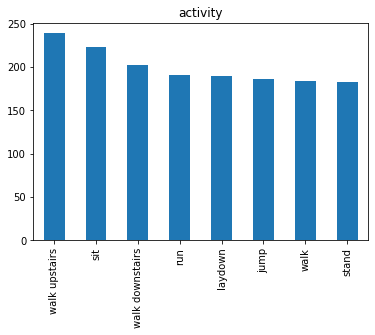

In [ ]:
pd.value_counts(df_range['label_first']).plot(kind='bar', title='activity');

## **PEMISAHAN TEXT DAN TRAIN DATA**

In [ ]:
from sklearn.model_selection import train_test_split

def split(train, test):
  train_x, test_x, train_label, test_label = train_test_split(train, test, test_size=2.5/10, random_state=0)
  return train_x, test_x, train_label, test_label

#1 Memisahkan fitur dan target
y = df_range.loc[:, ['label_first']].values.ravel()
x = df_range.drop('label_first', axis=1)

#2 Memisahkan train dan test data
train_x, test_x, train_label, test_label = split(x, y)
train_x = train_x.fillna(train_x.mean())
test_x = test_x.fillna(test_x.mean())
test_label.astype(object)
train_label.astype(object)

array(['jump', 'walk downstairs', 'sit', ..., 'walk downstairs', 'run',
       'sit'], dtype=object)

## **PEMODELAN**


1.   Support Vector Machine (SVM)




In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

encoder = preprocessing.LabelEncoder()
encoder.fit(train_label)
Y_train = encoder.transform(train_label)
encoder.fit(test_label)
Y_test = encoder.transform(test_label)
print (Y_train.shape)
print (train_x.shape)

params_grid = [{'kernel': ['poly'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'degree':[1,2]}, 
               {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000], 'degree':[1,2]}]
svm_model = GridSearchCV(SVC(), params_grid, cv=10)
svm_model.fit(train_x, Y_train)

print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C) 
print('Best Kernel:',svm_model.best_estimator_.kernel)
print('Best Gamma:',svm_model.best_estimator_.gamma)
print('Best Degree:',svm_model.best_estimator_.degree)

final_model = svm_model.best_estimator_
hasil = final_model.predict(test_x)
Y_hasil = list(encoder.inverse_transform(hasil))



(1199,)
(1199, 43)
Best score for training data: 0.6905252100840336 

Best C: 1000
Best Kernel: rbf
Best Gamma: 0.001
Best Degree: 1


SVM CONFUSION MATRIX

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_label,Y_hasil))
print(classification_report(test_label,Y_hasil))


[[37  0  4  0  0  1  0  1]
 [ 0 47  0  0  0  0  1  0]
 [ 9  0 41  0  0  0  2  2]
 [ 0  0  0 41  1  3  2  3]
 [ 0  0  0  1 42  1  3  0]
 [ 0  0  0  0  2 36  6  2]
 [ 0  0  3  0  1  8 27 13]
 [ 1  0  5  0  0  4  6 44]]
                 precision    recall  f1-score   support

           jump       0.79      0.86      0.82        43
        laydown       1.00      0.98      0.99        48
            run       0.77      0.76      0.77        54
            sit       0.98      0.82      0.89        50
          stand       0.91      0.89      0.90        47
           walk       0.68      0.78      0.73        46
walk downstairs       0.57      0.52      0.55        52
  walk upstairs       0.68      0.73      0.70        60

       accuracy                           0.79       400
      macro avg       0.80      0.79      0.79       400
   weighted avg       0.79      0.79      0.79       400



2. XGBOOST

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import time
#xgb = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0, 
                        #min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)
training_start = time.perf_counter()
training_end = time.perf_counter()
prediction_start = time.perf_counter()
prediction_end = time.perf_counter()

params_grid_xgb = [{'max_depth': [3, 4, 5, 6], 'learning_rate': [0.01, 0.001, 0.0001], 'n_estimators': [1, 10, 100, 1000], 
                   'gamma': [0.5, 0.6, 0.7, 0.8, 0.9], 'min_child_weight': [1, 10, 100, 1000], 'subsample':[0.8, 0.9, 0.10], 'colsample_bytree':[0.7, 0.8, 0.9], 'reg_alpha':[0.5, 0.05, 0.005]}]
xgb = GridSearchCV(XGBClassifier(), params_grid, cv=10)
xgb.fit(train_x, Y_train)

print('Best score for training data:', xgb.best_score_,"\n") 
# View the best parameters for the model found using grid search
print('Best max_depth:',xgb.best_estimator_.max_depth) 
print('Best learning rate:',xgb.best_estimator_.learning_rate)
print('Best n_estimators:',xgb.best_estimator_.n_estimators)
print('Best gamma:',xgb.best_estimator_.gamma) 
print('Best min_child_weight:',xgb.best_estimator_.min_child_weight)
print('Best subsample:',xgb.best_estimator_.subsample)
print('Best colsample_bytree:',xgb.best_estimator_.colsample_bytree)
print('Best reg_alpha:',xgb.best_estimator_.reg_alpha)



final_model_xgb = xgb.best_estimator_
preds = final_model_xgb.predict(test_x)
Y_hasil = list(encoder.inverse_transform(preds))

xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
accuracy_xgb = accuracy_score(Y_test, preds)

print("XGBoost's prediction accuracy is: %3.2f" % (accuracy_xgb))
#print("Time consumed for training: %4.3f" % (xgb_train_time))
#print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))



Best score for training data: 0.7456232492997199 

Best max_depth: 3
Best learning rate: 0.1
Best n_estimators: 100
Best gamma: 0.001
Best min_child_weight: 1
Best subsample: 1
Best colsample_bytree: 1
Best reg_alpha: 0
XGBoost's prediction accuracy is: 0.79


XGBOOST CONFUSION MATRIX

In [ ]:
print(confusion_matrix(test_label, test_label))
print(classification_report(test_label,Y_hasil))

[[43  0  0  0  0  0  0  0]
 [ 0 48  0  0  0  0  0  0]
 [ 0  0 54  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0]
 [ 0  0  0  0 47  0  0  0]
 [ 0  0  0  0  0 46  0  0]
 [ 0  0  0  0  0  0 52  0]
 [ 0  0  0  0  0  0  0 60]]
                 precision    recall  f1-score   support

           jump       0.79      0.86      0.82        43
        laydown       1.00      0.98      0.99        48
            run       0.77      0.76      0.77        54
            sit       0.98      0.82      0.89        50
          stand       0.91      0.89      0.90        47
           walk       0.68      0.78      0.73        46
walk downstairs       0.57      0.52      0.55        52
  walk upstairs       0.68      0.73      0.70        60

       accuracy                           0.79       400
      macro avg       0.80      0.79      0.79       400
   weighted avg       0.79      0.79      0.79       400

